Leiden followed by C means clustering of regulome

First make a proof of concept using igraph

Questions:
- How to measure distance
- How to measure membership
- How to treat small clusters - leave and expand or remove and add nodes to new?

If it works:
- make faster implementation


Problems:
- current distance measure: 
    - favors large clusters and nodes with high degree
    - maybe make measure of distance based on the number of nodes in the cluster
        - in a cluster of 10, 10 edges would make highly conncted to cluster, but in cluster of 100, 10 edges might not.
        - ideally, if node connected to all nodes, with 1 PPV - distance should be nearing 0, if no connection should be 1
        - 1 - (n_nodes_cluster/sum(distances))
            - this will favor smaller clusters

In [1]:
# Import packages

import igraph as ig
import pandas as pd
import numpy as np
import seaborn as sns
from compress_pickle import load, dump
from statistics import mean, median
from IPython.display import clear_output
from c_means_clustering import network_c_means
from copy import deepcopy
import itertools as it
import matplotlib.pyplot as plt
from math import log10

plt.style.use('bmh')

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

path = './files/'

In [2]:
# load regulome
regulome_network_edges = pd.read_csv(filepath_or_buffer=path+'/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_graph = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids=False)
# msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')
proteins = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).unique()

# del regulome_network_edges

In [3]:
# def leiden_clustering(graph, res, n_iter):
#     return graph.community_leiden(objective_function='modularity',
#                             weights='PPV',
#                             resolution=res,
#                             n_iterations=n_iter)

# leiden_clusters = leiden_clustering(regulome_graph, 4, 0.1, 10)
# clusters_dict = {n:set(regulome_graph.vs[node]['name'] for node in cluster) for (n, cluster) in enumerate(leiden_clusters)}

# with open(path+'c_means_leiden_clusters.gz', 'wb') as file:
#     dump(clusters_dict, file, compression='infer')

clusters_dict = open_pickle("c_means_leiden_clusters.gz")

In [ ]:
leiden_cluster_sizes = [len(cluster) for cluster in clusters_dict.values()]

fig, ax = plt.subplots(figsize=[6,4])


sns.histplot(leiden_cluster_sizes, binwidth=5, ax=ax)
fig.suptitle("Size distribution of Leiden clusters")
ax.set_xlabel("Cluster size")
ax.axvline(x=10, c='r', lw=2)
# fig.set_xlim([0, 20])
fig.savefig("./images/LiedenClustersDistr.png", dpi='figure')

In [ ]:
filtered_leiden = [cluster for cluster in leiden_cluster_sizes if cluster > 10]

print(f"Number of Leiden cluster: {len(leiden_cluster_sizes)}")
print(f"Number of filtered Leiden cluster: {len(filtered_leiden)}")
print(f"Median cluster size: {median(filtered_leiden)}")
print(f"Mean cluster size: {mean(filtered_leiden)}")

In [ ]:
with open(path+'path_lengths_dict.gz', 'rb') as file:
    path_lengths_dict = load(file, compression='infer')

In [4]:
results = network_c_means(regulome_graph, deepcopy(clusters_dict), 2, n_iter=1, optimize=True, distance_measure='edge_ratio', path_lengths=None, cores=6)

# normal - ~43 seconds, 1 iteration
# membership sae - 11, 1 iteration

Iteration 1 of 1


100%|██████████| 15041/15041 [00:40<00:00, 371.77it/s]


Updating Clusters: percentile 0.95


In [5]:
mean([len(cluster) for cluster in results[0][1].values()])

47.003125

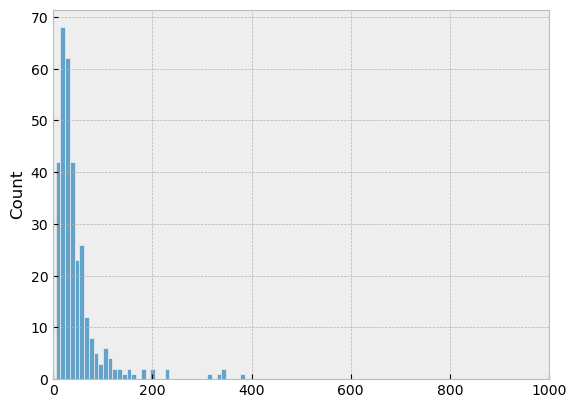

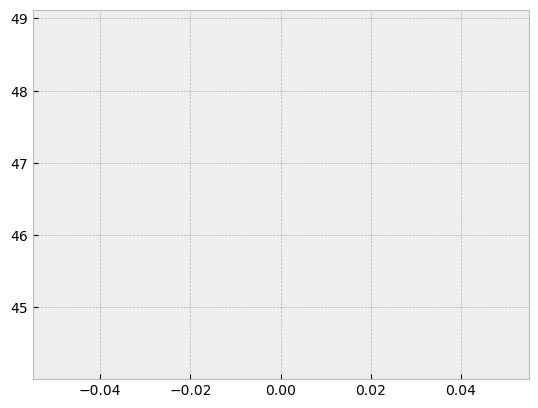

In [8]:
import matplotlib.pyplot as plt

fig = sns.histplot([len(cluster) for cluster in results[0][1].values()])
fig.set_xlim([0, 1000])
plt.show()

sns.lineplot(results[1])
plt.show()

In [ ]:
res = np.array([val for val in results['346909'].values()])
perc = np.percentile(res, 95)
print(perc)

print(len([cluster for (cluster, membership) in results['346909'].items() if membership >= perc]))

fig = sns.histplot(results['346909'])
fig.axvline(x=perc, c='r')

In [ ]:
nodes = [node for node in regulome_graph.vs['name']]

with open(path+'path_lengths.gz', 'rb') as file:
    path_lengths = load(file, compression='infer')

path_lengths = path_lengths[0]
path_lengths_dict = dict()
n_nodes = len(nodes)
for (node_number, node) in enumerate(nodes):
    clear_output()
    print(f'{node_number}/{n_nodes}')
    path_lengths_dict[node] = {
        other_node: round(path_lengths, 2)
        for (other_node, path_lengths) in zip(nodes, path_lengths[:n_nodes])
    }
    path_lengths = path_lengths[n_nodes:]
del path_lengths

with open(path+'path_lengths_dict.gz', 'wb') as file:
    dump(path_lengths_dict,path+'path_lengths_dict.gz', compression='infer')


In [9]:
from math import log10
from c_means_clustering import gather_neighbors, node_iteration
from joblib import Parallel, delayed

protein_edges = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).value_counts()
most_connected_proteins = tuple(protein_edges.index[:5])
least_connected_proteins = tuple(protein_edges[protein_edges>2].index[-5:])

# results = network_c_means(regulome_graph, deepcopy(clusters_dict), 2, n_iter=1, optimize=True, distance_measure='edge_rate', path_lengths=None)
m_values = [2]

most_connected_memberships = dict()
for m in m_values:
    most_connected_memberships[m] = network_c_means(regulome_graph, most_connected_proteins, deepcopy(clusters_dict), m, n_iter=1, optimize=False, distance_measure='edge_rate', path_lengths=None)


least_connected_memberships = dict()
for m in m_values:
    least_connected_memberships[m] = network_c_means(regulome_graph, least_connected_proteins, deepcopy(clusters_dict), m, n_iter=1, optimize=False, distance_measure='edge_rate', path_lengths=None)

TypeError: network_c_means() got multiple values for argument 'n_iter'

In [ ]:
protein = '336275'
print(protein_edges[protein])
m = 4

perc = np.percentile(np.array(list(least_connected_memberships[m][protein].values())), 95)
print(perc)
fig = sns.histplot(least_connected_memberships[m][protein])
fig.axvline(x=perc, c = 'r')
fig.axhline(y=1, c='b')
fig.set_ylim([0, 100])

see= [t for t in (least_connected_memberships[m][protein].values()) if t > perc]
print(see)
# sorted(tuple(least_connected_memberships[m][protein].values()))

In [ ]:
# most_connected_memberships

# Manually extract the keys and values
rows = [
    (m, protein, membership)
    for (m, proteins) in most_connected_memberships.items()
    for (protein, memberships) in proteins.items()
    for membership in memberships.values()
]

most_connected_df = pd.DataFrame(rows, columns=['fuzzy_m', 'Proteinid', 'membership'])

fig = sns.FacetGrid(most_connected_df, col='fuzzy_m', row='Proteinid')
fig.map(sns.histplot, 'membership')
fig.figure.subplots_adjust(top=0.925)
fig.set_xlabels('Membership (log10)')
fig.figure.suptitle("Membership distribution of the 5 proteins with the highest degree")
fig.refline(y=1, c='r')
# fig.savefig("./images/most_well_connected_sum_dist.png")

In [ ]:
# least_connected_memberships

# Manually extract the keys and values
rows = [
    (m, protein, membership)
    for (m, proteins) in least_connected_memberships.items()
    for (protein, memberships) in proteins.items()
    for membership in memberships.values()
]

least_connected_df = pd.DataFrame(rows, columns=['fuzzy_m', 'Proteinid', 'membership'])

fig = sns.FacetGrid(least_connected_df, col='fuzzy_m', row='Proteinid')
fig.map(sns.histplot, 'membership')
fig.figure.subplots_adjust(top=0.925)
fig.set_xlabels('Membership (log10)')
fig.figure.suptitle("Membership distribution of the 5 proteins with the lowest degree (more than 5)")
fig.refline(y=1, c='r')

# fig.savefig("./images/least_connected_sum_dist_not1.png")

In [ ]:
from itertools import chain

def calc_dist(graph, node, clusters):
    node_distances = dict()
    neighbors = set(graph.neighbors(node))

    for (cluster_id, cluster) in clusters.items():
        connected_nodes = set(neighbors).intersection(cluster)

        if len(connected_nodes) == 0: # no need if no connections
            node_distances[cluster_id] = 1
            continue

        # get weights of each connection to nodes in the cluster
        weights = [graph.es(graph.get_eid(node, connected_node))['PPV'] for connected_node in connected_nodes]
        weights_sum = sum(chain.from_iterable(weights))

        if weights_sum == 0: # dont need this myself, but a thing to look at if want to ship out later
            node_distances[cluster_id] = 1
            continue

        node_distances[cluster_id] = 1 / weights_sum
    return node_distances


def calc_membership(node_distances, m):
    node_memberships = dict()

    for (cluster_id, d) in node_distances.items():         
        fuzzy_exponent = 2 / (m - 1)

        # give better name - denomintation or membership function  
        membership_den = [(d / other_d) ** fuzzy_exponent for other_d in node_distances.values()]

        node_memberships[cluster_id] = 1 / sum(membership_den)

    return node_memberships


def optimization_function(node_distances, node_memberships, m): # change function name
    node_J = 0
    for cluster_id in node_distances.keys():
        node_J += node_memberships[cluster_id]**m * node_distances[cluster_id]**2
    return node_J
    

def network_c_means(graph, clusters, m, optimize=False):
    # add leiden here after 

    membership_dict = dict()
    distances_dict = dict()
    
    if optimize:
        Js = list()

    for i in range(0, 10):
        for node in graph.vs:
            node = node['name']
            node_distances = calc_dist(graph, node, clusters) # returns dictionary with distance to each cluster
            node_memberships = calc_membership(node_distances, m) # adds memberships of node to dictionary

            if optimize:
                Js.append(optimization_function(node_distances, node_memberships, m))
            distances_dict[node] = node_distances # maybe just add directly to dictionary
            membership_dict[node] = node_memberships

    

    return Js

memberships = network_c_means(regulome_graph, clusters_dict, 0.5, optimize=True)